<a href="https://colab.research.google.com/github/AnisMargo/gb/blob/main/Anisimova_%D0%9F%D1%80%D0%BE%D0%BC%D0%B5%D0%B6_%D0%B0%D1%82%D1%82%D0%B5%D1%81%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%BA%D1%83%D1%80%D1%81_Computer_Vision_%D0%B4%D0%BB%D1%8F_%D0%BC%D0%B5%D0%B4%D0%B8%D1%86%D0%B8%D0%BD%D1%81%D0%BA%D0%B8%D1%85_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Анисимова Маргарита**  
 **курс _Computer_Vision_для_медицинских_изображений**

# **Классификации изображений MNIST с использованием CNN**

**Выполнить задания помеченные #_ ! _# для всех трех типов фреймворков.**

## **PyTorch**

In [2]:
!pip install onnx   # Библиотека ONNX — Open Neural Network Exchange, открытый формат для обмена нейросетевыми моделями между разными фреймворками.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 157.3 MB/s eta 0:00:00


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import MNIST
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random
import onnx

In [4]:
# Использование GPU при наличии
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### **1. Загрузка данных**

In [5]:
# Трансформации: поворот + нормализация
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [6]:
# Загрузка данных
dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 341kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.96MB/s]


In [7]:
# Деление: 80% train, 10% val, 10% test
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
extra_test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, _ = random_split(dataset, [train_size, val_size, extra_test_size])

In [ ]:
#_!_# Провести эксперименты с разными значениями batch_size = [16, 32, 64, 128, 256] - например


**batch_size = 10**

In [8]:
# DataLoader
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### **2. Модель (CNN)**

In [9]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))        # (28-3+1)=26 → 13 after MaxPool
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))        # (13-3+1)=11 → 5 after MaxPool
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
#_!_# Сделать описание значений параметров сети:
#
# Например:  nn.Conv2d(1, 32, 3) - nn.Conv2d(in_channels, out_channels, kernel_size)



## 2.1 Описание архитектуры сверточной нейронной сети (CNNModel)

| **Слой**                         | **Параметры**                                        | **Описание (что делает слой)**                                                                        | **Как меняется размер тензора** |
| -------------------------------- | ---------------------------------------------------- | ----------------------------------------------------------------------------------------------------- | ------------------------------- |
| **Conv2d (1 → 32), kernel=3×3**  | `in_channels=1`  `out_channels=32`  `kernel_size=3`  | Первый сверточный слой. Извлекает простые признаки изображения: границы, линии, контрастные переходы. | (1, 28×28) → (32, 26×26)        |
| **ReLU**                         | —                                                    | Добавляет нелинейность. Обнуляет отрицательные значения, ускоряя обучение.                            | форма та же                     |
| **MaxPool2d 2×2**                | `kernel_size=2`                                      | Уменьшает высоту и ширину изображения в 2 раза. Делает сеть устойчивой к небольшим сдвигам и шумам.   | (32, 26×26) → (32, 13×13)       |
| **Conv2d (32 → 64), kernel=3×3** | `in_channels=32`  `out_channels=64`  `kernel_size=3` | Выделяет более сложные признаки: углы, пересечения линий, кривизны — важные элементы цифр.            | (32, 13×13) → (64, 11×11)       |
| **ReLU**                         | —                                                    | Нелинейность. Даёт модели возможность обучаться сложным зависимостям.                                 | форма та же                     |
| **MaxPool2d 2×2**                | `kernel_size=2`                                      | Вторичное уменьшение размера изображения вдвое.                                                       | (64, 11×11) → (64, 5×5)         |
| **Dropout (p=0.5)**              | `p=0.5`                                              | Во время обучения случайно "выключает" 50% нейронов, предотвращая переобучение.                       | форма та же                     |
| **Flatten**                      | —                                                    | Разворачивает объёмный тензор в вектор признаков.                                                     | (64×5×5=1600)                   |
| **Linear (1600 → 128)**          | `in_features=1600`  `out_features=128`               | Полносвязный слой — преобразует выделенные признаки в компактное внутреннее представление.            | 1600 → 128                      |
| **ReLU**                         | —                                                    | Нелинейность.                                                                                         | форма та же                     |
| **Linear (128 → 10)**            | `in_features=128`  `out_features=10`                 | Выходной слой. Каждый нейрон — вероятность принадлежности к цифрам 0–9.                               | 128 → 10                        |



### **3. Обучение модели**

In [10]:
#_!_# Провести эксперименты с разными значениями optim.ХХХ и lr=0.001

model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_val_acc = 0.0

for epoch in range(5):
    model.train()
    train_loss, correct, total = 0, 0, 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/10")

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loop.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

    # Валидация
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = val_correct / val_total
    print(f"Validation Accuracy: {val_acc:.4f}")

    # Сохранение лучшей модели
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

Epoch 1/10: 100%|██████████| 4800/4800 [00:33<00:00, 141.26it/s, accuracy=94.3, loss=0.0305]


Validation Accuracy: 0.9760


Epoch 2/10: 100%|██████████| 4800/4800 [00:31<00:00, 151.95it/s, accuracy=97.2, loss=0.00885]


Validation Accuracy: 0.9800


Epoch 3/10: 100%|██████████| 4800/4800 [00:30<00:00, 155.91it/s, accuracy=97.8, loss=0.00288]


Validation Accuracy: 0.9835


Epoch 4/10: 100%|██████████| 4800/4800 [00:30<00:00, 156.96it/s, accuracy=98.1, loss=0.0148]


Validation Accuracy: 0.9853


Epoch 5/10: 100%|██████████| 4800/4800 [00:30<00:00, 157.80it/s, accuracy=98.3, loss=0.00107]


Validation Accuracy: 0.9842


### **4. Тестирование модели и визуализация**

In [11]:
# Загрузка модели
model = CNNModel().to(device)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [12]:
# Accuracy на тесте
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {correct / total:.4f}")

Test Accuracy: 0.9893


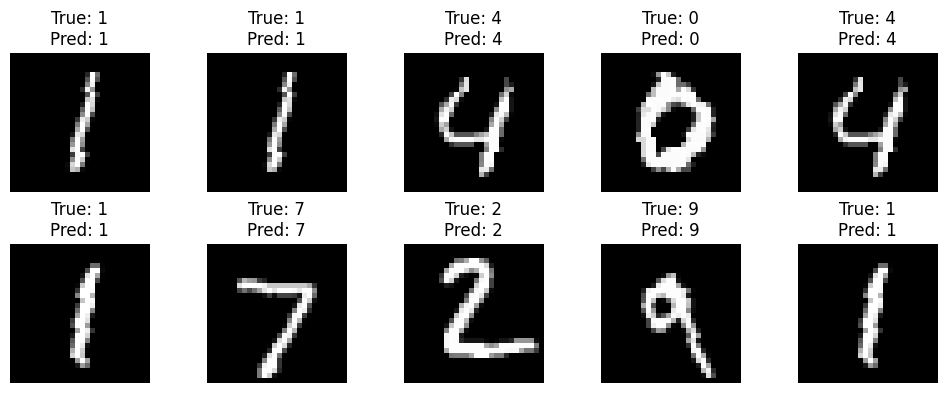

In [13]:
# Визуализация 10 случайных предсказаний
def imshow(img):
    img = img * 0.3081 + 0.1307  # денормализация
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.axis('off')

model.eval()
examples = next(iter(test_loader))
images, labels = examples
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

fig = plt.figure(figsize=(10, 4))
for i in range(10):
    idx = random.randint(0, images.size(0) - 1)
    plt.subplot(2, 5, i+1)
    imshow(images[idx].cpu())
    plt.title(f"True: {labels[idx].item()}\nPred: {predicted[idx].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()


**batch_size = 64**

In [14]:
# DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [15]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))        # (28-3+1)=26 → 13 after MaxPool
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))        # (13-3+1)=11 → 5 after MaxPool
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [16]:
#_!_# Провести эксперименты с разными значениями optim.ХХХ и lr=0.001

model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_val_acc = 0.0

for epoch in range(5):
    model.train()
    train_loss, correct, total = 0, 0, 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/10")

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loop.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

    # Валидация
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = val_correct / val_total
    print(f"Validation Accuracy: {val_acc:.4f}")

    # Сохранение лучшей модели
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

Epoch 1/10: 100%|██████████| 750/750 [00:17<00:00, 43.03it/s, accuracy=93.2, loss=0.0804]


Validation Accuracy: 0.9728


Epoch 2/10: 100%|██████████| 750/750 [00:17<00:00, 43.73it/s, accuracy=97.3, loss=0.0466]


Validation Accuracy: 0.9803


Epoch 3/10: 100%|██████████| 750/750 [00:17<00:00, 43.33it/s, accuracy=97.8, loss=0.0557]


Validation Accuracy: 0.9857


Epoch 4/10: 100%|██████████| 750/750 [00:17<00:00, 43.28it/s, accuracy=98.1, loss=0.01]


Validation Accuracy: 0.9855


Epoch 5/10: 100%|██████████| 750/750 [00:17<00:00, 42.46it/s, accuracy=98.3, loss=0.15]


Validation Accuracy: 0.9853


In [17]:
# Загрузка модели
model = CNNModel().to(device)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [18]:
# Accuracy на тесте
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {correct / total:.4f}")

Test Accuracy: 0.9875


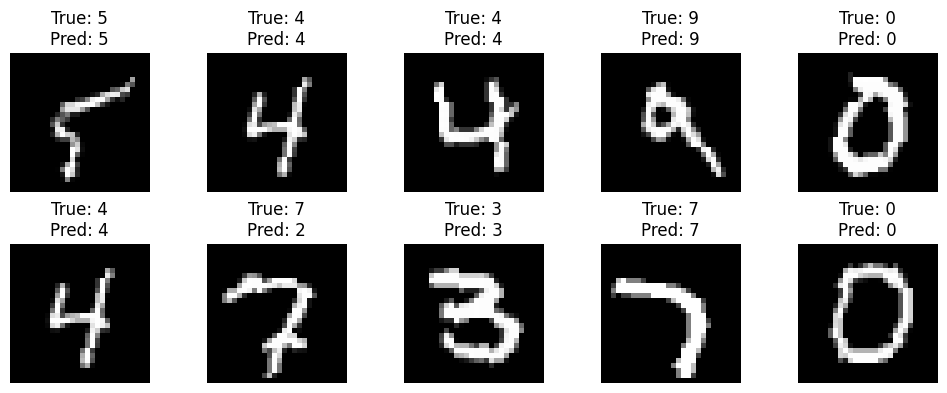

In [19]:
# Визуализация 10 случайных предсказаний
def imshow(img):
    img = img * 0.3081 + 0.1307  # денормализация
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.axis('off')

model.eval()
examples = next(iter(test_loader))
images, labels = examples
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

fig = plt.figure(figsize=(10, 4))
for i in range(10):
    idx = random.randint(0, images.size(0) - 1)
    plt.subplot(2, 5, i+1)
    imshow(images[idx].cpu())
    plt.title(f"True: {labels[idx].item()}\nPred: {predicted[idx].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()


**batch_size = 256**

In [20]:
# DataLoader
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [21]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))        # (28-3+1)=26 → 13 after MaxPool
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))        # (13-3+1)=11 → 5 after MaxPool
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

**Adam** (Adaptive Moment Estimation) — это оптимизатор, который сочетает в себе преимущества двух методов: Momentum (учитывает предыдущие градиенты для ускорения сходимости) и RMSProp (адаптирует скорость обучения для каждого параметра)

In [22]:
#_!_# Adam

model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_val_acc = 0.0

for epoch in range(5):
    model.train()
    train_loss, correct, total = 0, 0, 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/10")

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loop.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

    # Валидация
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = val_correct / val_total
    print(f"Validation Accuracy: {val_acc:.4f}")

    # Сохранение лучшей модели
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

Epoch 1/10: 100%|██████████| 188/188 [00:14<00:00, 12.59it/s, accuracy=90.2, loss=0.171]


Validation Accuracy: 0.9642


Epoch 2/10: 100%|██████████| 188/188 [00:14<00:00, 12.71it/s, accuracy=96.5, loss=0.153]


Validation Accuracy: 0.9762


Epoch 3/10: 100%|██████████| 188/188 [00:14<00:00, 12.68it/s, accuracy=97.5, loss=0.0671]


Validation Accuracy: 0.9800


Epoch 4/10: 100%|██████████| 188/188 [00:14<00:00, 12.53it/s, accuracy=97.9, loss=0.0332]


Validation Accuracy: 0.9832


Epoch 5/10: 100%|██████████| 188/188 [00:15<00:00, 12.47it/s, accuracy=98, loss=0.0154]


Validation Accuracy: 0.9857


In [23]:
# Загрузка модели
model = CNNModel().to(device)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [24]:
# Accuracy на тесте
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {correct / total:.4f}")

Test Accuracy: 0.9894


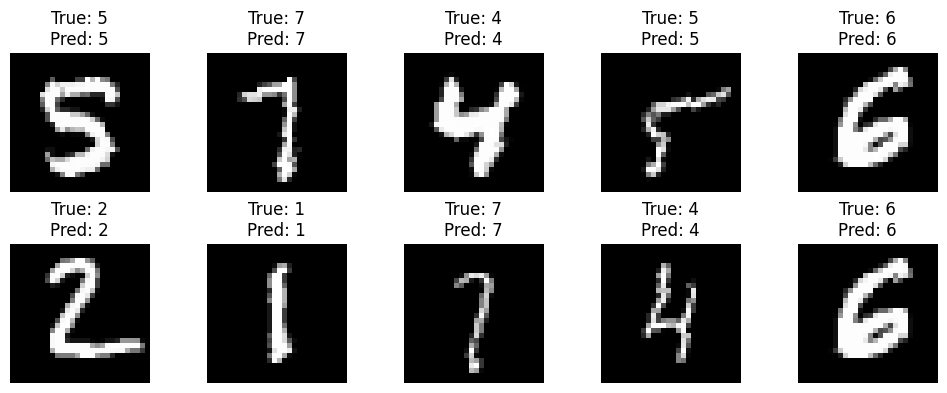

In [25]:
# Визуализация 10 случайных предсказаний
def imshow(img):
    img = img * 0.3081 + 0.1307  # денормализация
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.axis('off')

model.eval()
examples = next(iter(test_loader))
images, labels = examples
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

fig = plt.figure(figsize=(10, 4))
for i in range(10):
    idx = random.randint(0, images.size(0) - 1)
    plt.subplot(2, 5, i+1)
    imshow(images[idx].cpu())
    plt.title(f"True: {labels[idx].item()}\nPred: {predicted[idx].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
#_!_# Написать вывод, как изменилось качество модели с изменением параметров

# Вывод
 Сравнительный анализ влияния размера батча на обучение нейронной сети

И так были протестированы три различных размера батча: 10, 64 и 256, при использовании оптимизатора Adam. Результаты демонстрируют явный компромисс между скоростью обучения и эффективностью использования вычислительных ресурсов.

При минимальном размере батча 10 модель достигла высокой точности 98.93%, однако время обучения составило около 30 секунд. Такой небольшой размер батча обеспечивает частые обновления весов и потенциально более плавный спуск в пространстве функции потерь, но требует большего количества итераций на одну эпоху, что существенно замедляет процесс обучения.

Увеличение размера батча до 64 позволило значительно сократить время обучения до 17 секунд при незначительном снижении точности до 98.75%. Этот вариант представляет собой разумный баланс между скоростью обучения и качеством модели. Более крупные батчи позволяют эффективнее использовать параллельные вычисления на GPU, уменьшая накладные расходы на обработку данных, при этом сохраняя достаточную статистическую надежность оценок градиента.

Наибольший размер батча 256 показал наилучшие результаты как по скорости обучения (14 секунд), так и по конечной точности (98.94%). Крупные батчи обеспечивают более стабильные оценки градиента за счет уменьшения дисперсии, что в данном случае положительно сказалось на обобщающей способности модели. Кроме того, они позволяют максимально эффективно использовать вычислительные ресурсы современного оборудования для глубокого обучения.

Выбрав оптимальный размер батча 256 переходим к следующему этапу исследования - сравнительному анализу различных оптимизаторов.

Последующий анализ продемонстрирует, насколько различные алгоритмы оптимизации способны эффективно использовать преимущества крупного размера батча и какие из них обеспечивают наилучшее сочетание скорости сходимости и итоговой точности предсказаний.

**Задание: Провести эксперименты с разными значениями optim.ХХХ и lr=0.001**

**SGD**

**SGD with Momentum (стохастический градиентный спуск с импульсом)** — это оптимизатор, который добавляет "инерцию" к процессу градиентного спуска. Принцип его работы аналогичен движению шарика, скатывающегося с холма: вместо того чтобы сразу менять направление при каждом шаге, оптимизатор сохраняет часть предыдущего обновления и добавляет её к текущему. Это позволяет преодолевать локальные минимумы и быстрее сходиться к глобальному оптимуму.

In [26]:
# DataLoader
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [27]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))        # (28-3+1)=26 → 13 after MaxPool
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))        # (13-3+1)=11 → 5 after MaxPool
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [39]:
#_!_# optimizer_sgd

model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_sgd = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

best_val_acc = 0.0

for epoch in range(5):
    model.train()
    train_loss, correct, total = 0, 0, 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/10")

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loop.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

    # Валидация
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = val_correct / val_total
    print(f"Validation Accuracy: {val_acc:.4f}")

    # Сохранение лучшей модели
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

Epoch 1/10: 100%|██████████| 188/188 [00:14<00:00, 12.70it/s, accuracy=10.3, loss=2.31]


Validation Accuracy: 0.0715


Epoch 2/10: 100%|██████████| 188/188 [00:14<00:00, 12.67it/s, accuracy=10.3, loss=2.29]


Validation Accuracy: 0.0717


Epoch 3/10: 100%|██████████| 188/188 [00:14<00:00, 12.58it/s, accuracy=10.1, loss=2.3]


Validation Accuracy: 0.0720


Epoch 4/10: 100%|██████████| 188/188 [00:14<00:00, 12.66it/s, accuracy=10.2, loss=2.31]


Validation Accuracy: 0.0700


Epoch 5/10: 100%|██████████| 188/188 [00:14<00:00, 12.69it/s, accuracy=10.1, loss=2.31]


Validation Accuracy: 0.0718


In [29]:
# Загрузка модели
model = CNNModel().to(device)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [30]:
# Accuracy на тесте
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {correct / total:.4f}")

Test Accuracy: 0.0654


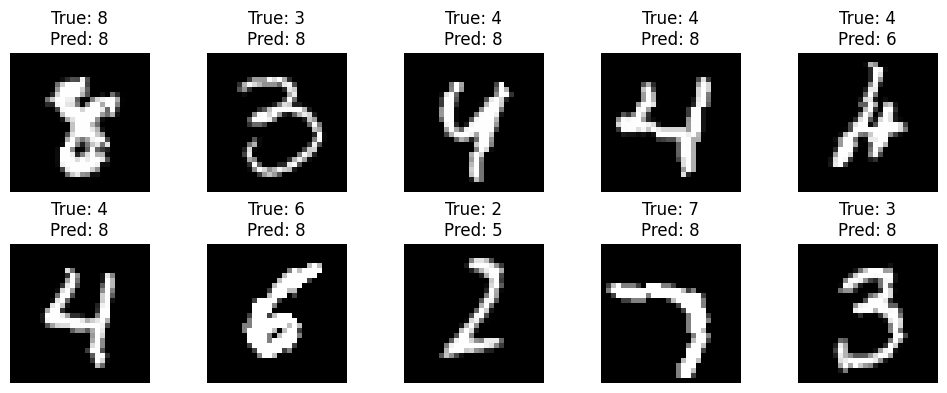

In [31]:
# Визуализация 10 случайных предсказаний
def imshow(img):
    img = img * 0.3081 + 0.1307  # денормализация
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.axis('off')

model.eval()
examples = next(iter(test_loader))
images, labels = examples
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

fig = plt.figure(figsize=(10, 4))
for i in range(10):
    idx = random.randint(0, images.size(0) - 1)
    plt.subplot(2, 5, i+1)
    imshow(images[idx].cpu())
    plt.title(f"True: {labels[idx].item()}\nPred: {predicted[idx].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

**rmsprop**     
**RMSprop (Root Mean Square Propagation - «распространение среднеквадратичного значения»)** — адаптивный алгоритм оптимизации, который автоматически регулирует скорость обучения для каждого параметра модели на основе скользящего среднего квадратов градиентов. :

- **Root Mean Square** — вычисляет среднее квадратов градиентов за предыдущие шаги,  
- **Propagation** — адаптивно применяет это значение для масштабирования скорости обучения.

RMSprop уменьшает скорость обучения для параметров с большими градиентами и увеличивает — для параметров с малыми, что помогает стабилизировать обучение в задачах с шумом или разреженными градиентами. В отличие от Adam, он не использует момент первых порядков, а фокусируется только на втором моменте (дисперсии градиентов).


In [32]:
# DataLoader
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [33]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))        # (28-3+1)=26 → 13 after MaxPool
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))        # (13-3+1)=11 → 5 after MaxPool
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [40]:
#_!_# optimizer_rmsprop = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99)

model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_rmsprop = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99)
best_val_acc = 0.0

for epoch in range(5):
    model.train()
    train_loss, correct, total = 0, 0, 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/10")

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loop.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

    # Валидация
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = val_correct / val_total
    print(f"Validation Accuracy: {val_acc:.4f}")

    # Сохранение лучшей модели
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

Epoch 1/10: 100%|██████████| 188/188 [00:14<00:00, 12.66it/s, accuracy=10.5, loss=2.31]


Validation Accuracy: 0.1285


Epoch 2/10: 100%|██████████| 188/188 [00:14<00:00, 12.66it/s, accuracy=10.7, loss=2.33]


Validation Accuracy: 0.1318


Epoch 3/10: 100%|██████████| 188/188 [00:14<00:00, 12.57it/s, accuracy=10.8, loss=2.32]


Validation Accuracy: 0.1300


Epoch 4/10: 100%|██████████| 188/188 [00:14<00:00, 12.69it/s, accuracy=10.6, loss=2.3]


Validation Accuracy: 0.1307


Epoch 5/10: 100%|██████████| 188/188 [00:14<00:00, 12.56it/s, accuracy=10.9, loss=2.32]


Validation Accuracy: 0.1300


In [35]:
# Загрузка модели
model = CNNModel().to(device)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [36]:
# Accuracy на тесте
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {correct / total:.4f}")

Test Accuracy: 0.1336


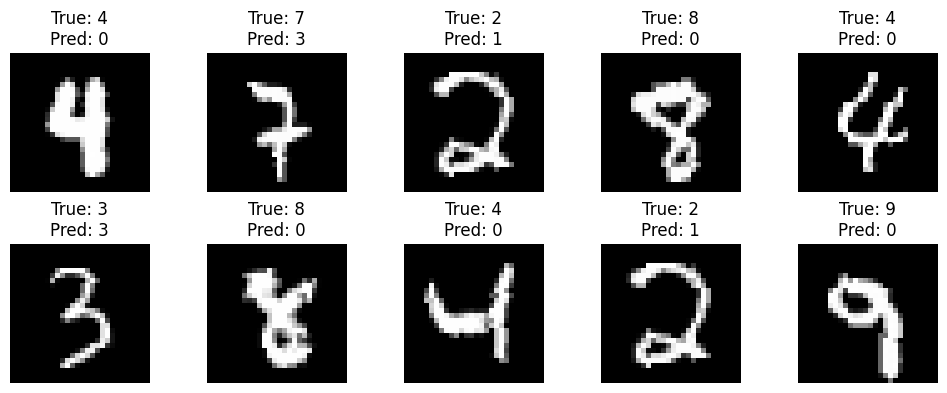

In [37]:
# Визуализация 10 случайных предсказаний
def imshow(img):
    img = img * 0.3081 + 0.1307  # денормализация
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.axis('off')

model.eval()
examples = next(iter(test_loader))
images, labels = examples
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

fig = plt.figure(figsize=(10, 4))
for i in range(10):
    idx = random.randint(0, images.size(0) - 1)
    plt.subplot(2, 5, i+1)
    imshow(images[idx].cpu())
    plt.title(f"True: {labels[idx].item()}\nPred: {predicted[idx].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Вывод

Я протестировала три оптимизатора на простой задаче распознавания рукописных цифр (MNIST). Результаты оказались разными:

- **Adam** показал лучший результат — 98% точности. Он работает стабильно и не требует сложных настроек, поэтому отлично подошел для сегодняшней задачи.

- **SGD с Momentum** и **RMSprop** показали низкую точность (6.54% и 13.36%). Это произошло потому, что они чувствительны к настройкам. Если правильно подобрать параметры, они могут работать хорошо, но это требует времени и экспериментов.

**Когда что использовать:**

- **Adam** — для быстрых и надежных результатов.
- **SGD с Momentum** — если есть время и ресурсы для тонкой настройки.
- **RMSprop** — для специфических задач, например, работы с рекуррентными сетями.

**Итог:** Adam — оказался оптимальным выбором для нашей задачи, так как он сочетает высокую точность и простоту использования.



## **TensorFlow с использованием Keras**

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

### **1. Загрузка и подготовка данных**

In [ ]:
# Загрузка данных
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Нормализация и добавление канала
x_train_full = x_train_full.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train_full = np.expand_dims(x_train_full, -1)  # -> (28, 28, 1)
x_test = np.expand_dims(x_test, -1)

In [ ]:
# Разделение на train (80%), val (10%), test (10%)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=0.2, random_state=42
)
val_size = int(0.5 * len(x_val))
x_val, x_extra_test = x_val[:val_size], x_val[val_size:]
y_val, y_extra_test = y_val[:val_size], y_val[val_size:]
x_test = np.concatenate([x_test, x_extra_test])
y_test = np.concatenate([y_test, y_extra_test])

### **2. Создание tf.data.Dataset пайплайна**

In [ ]:
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

### **3. Модель (Sequential CNN)**

In [ ]:
model = models.Sequential([
    Input(shape=(28, 28, 1)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10)
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

### **4. Компиляция и обучение**

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
# Колбэки
checkpoint_cb = ModelCheckpoint("best_model.keras", save_best_only=True)
earlystop_cb = EarlyStopping(patience=3, restore_best_weights=True)

In [ ]:
# Обучение
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint_cb, earlystop_cb]
)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9921 - loss: 0.0234 - val_accuracy: 0.9930 - val_loss: 0.0284
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9926 - loss: 0.0213 - val_accuracy: 0.9913 - val_loss: 0.0365
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9927 - loss: 0.0223 - val_accuracy: 0.9928 - val_loss: 0.0306
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9941 - loss: 0.0169 - val_accuracy: 0.9925 - val_loss: 0.0309


### **5. Сохранение и загрузка модели**

In [ ]:
# Сохранение в .h5
model.save("mnist_model.h5")

# Сохранение в формате Keras
model.save("mnist_model.keras")

# Загрузка модели
model_loaded = tf.keras.models.load_model("mnist_model.h5")

### **6. Тестирование и визуализация**

In [ ]:
# Оценка на тесте
test_loss, test_acc = model_loaded.evaluate(test_ds)
print(f"\nTest Accuracy: {test_acc:.4f}")

500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9907 - loss: 0.0283

Test Accuracy: 0.9921


In [ ]:
# Предсказания
y_pred = model_loaded.predict(test_ds)
y_pred_labels = np.argmax(y_pred, axis=1)

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
# Истинные метки
y_true = np.concatenate([y for _, y in test_ds], axis=0)

In [ ]:
# Матрица ошибок
cm = confusion_matrix(y_true, y_pred_labels)

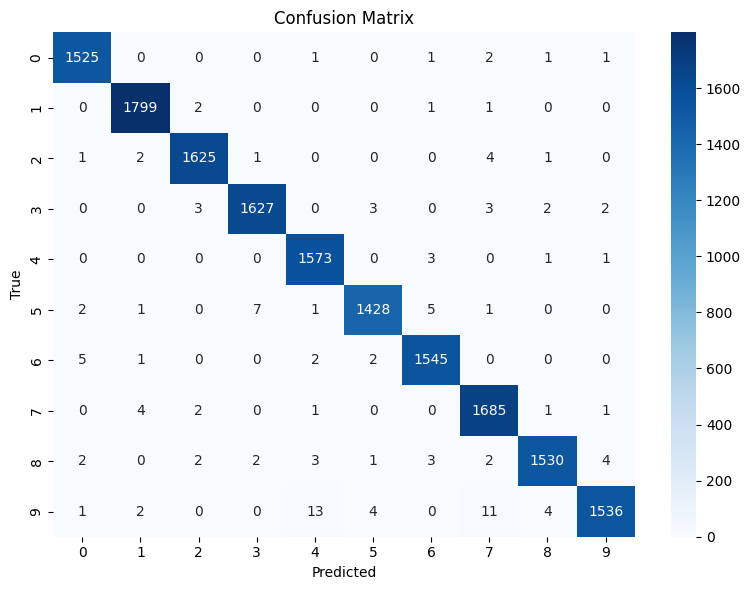

In [ ]:
# Визуализация
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

## **Keras (не через tf.keras)**

In [ ]:
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler
from keras.models import model_from_json
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from PIL import Image

### **1. Загрузка и подготовка данных**

In [ ]:
# Загрузка данных
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
# Преобразование и нормализация
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

In [ ]:
# Добавляем канал
x_train = np.expand_dims(x_train, axis=-1)  # (28, 28, 1)
x_test = np.expand_dims(x_test, axis=-1)

In [ ]:
# One-hot encoding
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

### **2. Модель (Functional API)**

In [ ]:
inputs = Input(shape=(28, 28, 1))
x = Conv2D(32, 3, activation='relu')(inputs)
x = MaxPooling2D(2)(x)
x = Conv2D(64, 3, activation='relu')(x)
x = MaxPooling2D(2)(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs, outputs)
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

### **3. Компиляция и обучение**

In [ ]:
# Компиляция
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Колбэки
csv_logger = CSVLogger("training_log.csv")
checkpoint = ModelCheckpoint("best.weights.h5", save_best_only=True, save_weights_only=True)

In [ ]:
# Планировщик скорости обучения
def scheduler(epoch, lr):
    if epoch == 5:
        return lr * 0.1
    return lr

lr_scheduler = LearningRateScheduler(scheduler)

In [ ]:
# Обучение
history = model.fit(
    x_train, y_train_cat,
    validation_split=0.1,
    epochs=10,
    batch_size=32,
    callbacks=[csv_logger, checkpoint, lr_scheduler]
)

Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8716 - loss: 0.3991 - val_accuracy: 0.9840 - val_loss: 0.0538 - learning_rate: 0.0010
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9759 - loss: 0.0711 - val_accuracy: 0.9887 - val_loss: 0.0400 - learning_rate: 0.0010
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9843 - loss: 0.0512 - val_accuracy: 0.9892 - val_loss: 0.0334 - learning_rate: 0.0010
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9870 - loss: 0.0405 - val_accuracy: 0.9923 - val_loss: 0.0254 - learning_rate: 0.0010
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9887 - loss: 0.0327 - val_accuracy: 0.9903 - val_loss: 0.0310 - learning_rate: 0.0010
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9920 - loss: 0.0251 - val_accuracy: 0.9933 - val_loss: 0.0247 - learning_rate: 1.0000e-04
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9

### **4. Сохранение и загрузка модели**

In [ ]:
# Сохранение
model_json = model.to_json()
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.weights.h5")

In [ ]:
# Загрузка
with open("model_architecture.json", "r") as json_file:
    loaded_json = json_file.read()

model_loaded = model_from_json(loaded_json)
model_loaded.load_weights("model.weights.h5")

### **5. Тестирование и графики**

In [ ]:
# Предсказания
y_pred_probs = model_loaded.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
# Классификационный отчёт
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       0.99      1.00      0.99      1032
           3       1.00      1.00      1.00      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      1.00       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.99      1.00       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



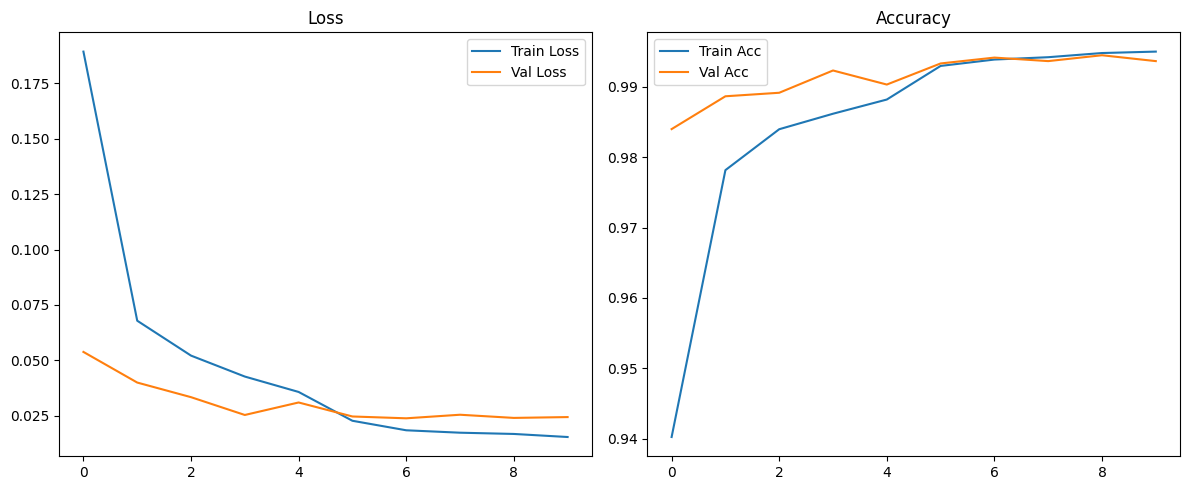

In [ ]:
# Графики
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

### **6. Пример предсказания на новой цифре (через PIL)**

In [ ]:
def predict_digit(image_path):
    img = Image.open(image_path).convert("L").resize((28, 28))
    img_arr = np.array(img)
    img_arr = 255 - img_arr  # инверсия для белой цифры на чёрном фоне
    img_arr = img_arr.astype("float32") / 255.0
    img_arr = np.expand_dims(img_arr, axis=(0, -1))  # (1, 28, 28, 1)

    prediction = model_loaded.predict(img_arr)
    return np.argmax(prediction), prediction

In [ ]:
# Пример:
digit, probs = predict_digit("my_digit.png")
print("Предсказано:", digit)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
Предсказано: 5
